### 0. Initialisation

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import model_selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest


In [29]:
cwd = os.path.join(os.getcwd(), '..')
DATA_IN_FOLDER = os.path.join(cwd, 'data', 'curated')
DATA_OUT_FOLDER = os.path.join(cwd, 'data', 'out')

### 1. Exploratory Data Analysis

In [30]:
#Work with Homes, Sells
global_data = pd.read_csv(os.path.join(DATA_IN_FOLDER, 'Maison_valeursfoncieres.csv'), encoding='utf-8', sep=';', decimal='.')

global_data = global_data[global_data['Nature mutation'] == 'Vente']

# Check the number of data points in the data set
print(f'number of Homes sold : {len(global_data)}')
# Check the number of features in the data set
print(f'number of columns : {len(global_data.columns)}'   )
# Check the data types
print(f'data types : {global_data.dtypes.unique()}')

print('non numerical columns : ' + str(global_data.select_dtypes(include=['O']).columns.tolist()))
# Check any number of columns with NaN
print(f'number of columns with any NaN values : {global_data.isnull().any().sum()} / {len(global_data.columns)}')
# Check any number of data points with NaN
print(f'number of rows with any NaN values : {global_data.isnull().any(axis=1).sum()} / {len(global_data)}')


number of Homes sold : 511136
number of columns : 8
data types : [dtype('O') dtype('int64') dtype('float64')]
non numerical columns : ['Nature mutation']
number of columns with any NaN values : 0 / 8
number of rows with any NaN values : 0 / 511136


### Cleanup limits

In [31]:
curated_data = global_data.copy(deep=True)

count    511136.000000
mean        103.268034
std          46.531960
min           0.000000
25%          75.000000
50%          95.000000
75%         123.000000
max        1110.000000
Name: Surface reelle bati, dtype: float64


Text(0.5, 0.98, 'Surface batie')

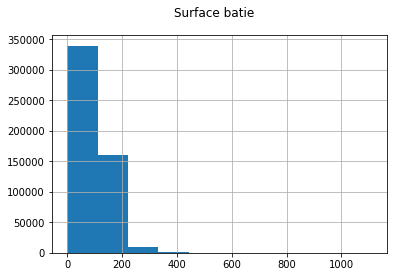

In [32]:
print(global_data['Surface reelle bati'].describe())
global_data['Surface reelle bati'].hist()
plt.suptitle('Surface batie')

Text(0.5, 0.98, 'Surface batie')

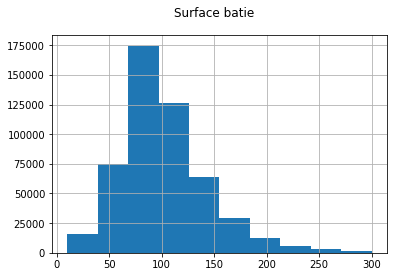

In [33]:
#drop surfaces between 20 and 300
curated_data.drop(curated_data[(curated_data['Surface reelle bati']<10 ) | (curated_data['Surface reelle bati']> 300 )].index, inplace=True)
curated_data['Surface reelle bati'].hist()
plt.suptitle('Surface batie')

count    511136.000000
mean          4.260539
std           1.519246
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          67.000000
Name: Nombre pieces principales, dtype: float64


Text(0.5, 0.98, 'Number of room')

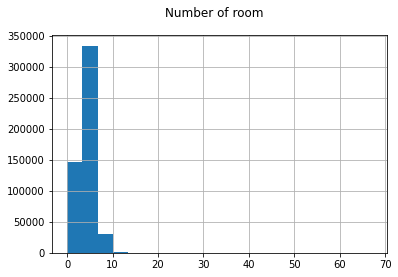

In [34]:
print(global_data['Nombre pieces principales'].describe())
global_data['Nombre pieces principales'].hist(bins=20)
plt.suptitle('Number of room')

Text(0.5, 0.98, 'Number of room')

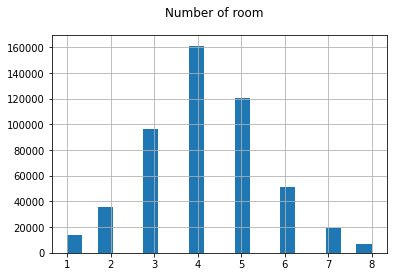

In [35]:
curated_data.drop(curated_data[(curated_data['Nombre pieces principales']> 8 )].index, inplace=True)
curated_data.loc[curated_data['Nombre pieces principales'] == 0] = 1
curated_data['Nombre pieces principales'].hist(bins=20)
plt.suptitle('Number of room')

count    511136.000000
mean        813.530109
std        2903.795869
min           0.000000
25%         238.000000
50%         500.000000
75%         800.000000
max      549300.000000
Name: Surface terrain, dtype: float64


Text(0.5, 0.98, 'Surface terrain')

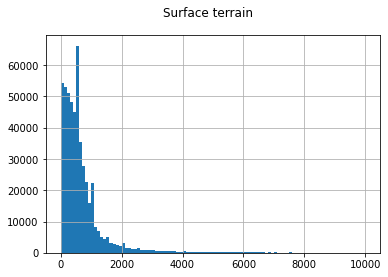

In [36]:
print(global_data['Surface terrain'].describe())
global_data['Surface terrain'].hist(bins=100, range=(0,10000))
plt.suptitle('Surface terrain')

Text(0.5, 0.98, 'Surface terrain')

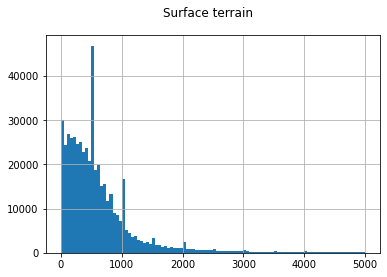

In [37]:
curated_data.drop(curated_data[(curated_data['Surface terrain']> 5000 )].index, inplace=True)
curated_data['Surface terrain'].hist(bins=100)
plt.suptitle('Surface terrain')

count    5.111360e+05
mean     3.264928e+05
std      5.743433e+06
min      1.500000e-01
25%      1.180000e+05
50%      1.844000e+05
75%      2.900000e+05
max      2.086000e+09
Name: Valeur fonciere, dtype: float64


Text(0.5, 0.98, 'Valeur fonciere')

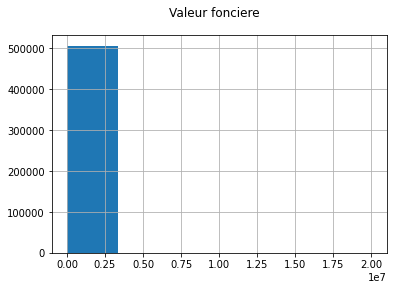

In [38]:
print(global_data['Valeur fonciere'].describe())
global_data['Valeur fonciere'].hist(bins=6, range=(10000,20000000))
plt.suptitle('Valeur fonciere')

Text(0.5, 0.98, 'Valeur fonciere')

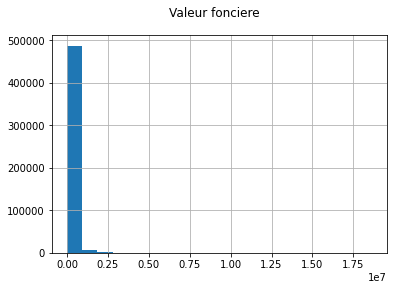

In [39]:
curated_data.drop(curated_data[(curated_data['Valeur fonciere']> 20000000 ) | (curated_data['Valeur fonciere'] < 10000)].index, inplace=True)
curated_data['Valeur fonciere'].hist(bins=20)
plt.suptitle('Valeur fonciere')


In [40]:
#store dataset as final dataset 
curated_data.to_csv(os.path.join(DATA_OUT_FOLDER, 'Maison_valeursfoncieres.csv'), index=False)


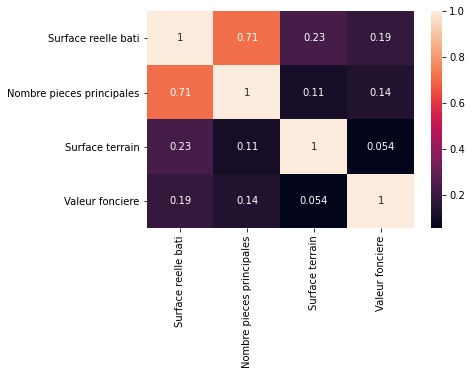

In [41]:

# New correlation matrix
matrix = curated_data[['Surface reelle bati','Nombre pieces principales','Surface terrain','Valeur fonciere']]
mat_corr = matrix.corr().round(5)
sns.heatmap(data=mat_corr, annot=True)
del(matrix)


### 2. Correlations between features and target

In [42]:

features = curated_data.iloc[:,3:].columns.tolist()
target = curated_data.iloc[:,2].name

correlations = {}
for f in features:
    data_temp = curated_data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    del(data_temp)

data_correlations = pd.DataFrame(correlations, index=['Value']).T
print(data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index])
del(data_correlations, x1, x2)

                                                 Value
Surface reelle bati vs Valeur fonciere        0.186078
Nombre pieces principales vs Valeur fonciere  0.136563
Surface terrain vs Valeur fonciere            0.054036
Latitude vs Valeur fonciere                  -0.049737
Longitude vs Valeur fonciere                  0.038421


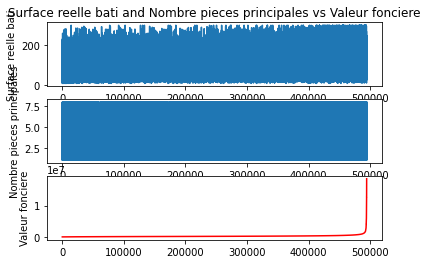

In [43]:

y = curated_data.loc[:,['Surface reelle bati','Nombre pieces principales', target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Surface reelle bati and Nombre pieces principales vs Valeur fonciere')
plt.ylabel('Surface reelle bati')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Nombre pieces principales')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel('Valeur fonciere')


plt.show()
del(x)



In [44]:

def compute_distance(lat1, lon1, lat2, lon2):
    R = 6372800  # Earth radius in meters

    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_distance = 6372800 * c
    return np.rint(total_distance/1000)



In [45]:
coord_gps = pd.read_csv(os.path.join(DATA_OUT_FOLDER, 'coord_gps_referential.csv'), encoding='utf-8', sep=';')
from_city = coord_gps[coord_gps['Code INSEE'] == '63113']

lat1, lon1 = [from_city['Latitude'].values[0], from_city['Longitude'].values[0]]

curated_data['distance'] = compute_distance(lat1, lon1, curated_data['Latitude'].values, curated_data['Longitude'].values)

working_data = curated_data[curated_data['distance'] < 50]

print('Number of sells found : ' + str(len(working_data)))
del(coord_gps)

Number of sells found : 4897


In [46]:
#Use Isolation forest model to finalize cleanup of dataset
df = working_data[['Surface reelle bati','Nombre pieces principales','Surface terrain', 'Valeur fonciere', 'distance']]

iForest = IsolationForest(n_estimators=100,  contamination=0.1 , random_state=42, max_samples=200)
iForest.fit(df)

df['anomaly'] = iForest.predict(df)
print('number of anomalies found : %s' % len(df[df['anomaly'] == -1]))

working_data.drop(df.loc[df['anomaly'] == -1].index, inplace=True)

print('new number of data : %s' % len(working_data))


number of anomalies found : 490
new number of data : 4407


In [47]:
regr = LinearRegression()

X =  working_data[['Surface reelle bati','Nombre pieces principales','Surface terrain']].values
y = working_data['Valeur fonciere'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y ,test_size=0.3)


In [48]:
regr.fit(X_train, y_train)
score = regr.score(X_test,y_test)
print("Training score xith skLearn: ", score)


Training score xith skLearn:  0.27289494271533876


In [49]:
scores = cross_val_score(regr, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.25


In [50]:
# Calculate the Root Mean Squared Error
print("RMSE: L'erreur quadratique moyenne est de %.2f€"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))


RMSE: L'erreur quadratique moyenne est de 76416.81€


In [51]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,                    colsample_bytree=1, max_depth=7)

xgb.fit(X_train,y_train)

score = xgb.score(X_train, y_train)  
print("Training score xith Xgboost: ", score)


Training score xith Xgboost:  0.7003967925633122


In [52]:
scores = cross_val_score(xgb, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())


Mean cross-validation score: 0.35


In [53]:
# Calculate the Root Mean Squared Error
print("RMSE: L'erreur quadratique moyenne est de %.2f€"
      % math.sqrt(np.mean((xgb.predict(X_test) - y_test) ** 2)))

RMSE: L'erreur quadratique moyenne est de 73354.52€


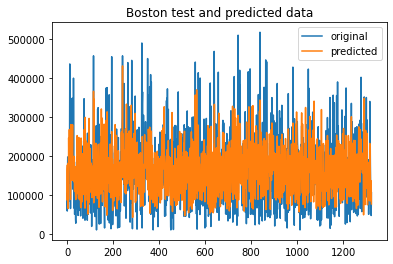

In [54]:
ypred = xgb.predict(X_test)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")

plt.title("Boston test and predicted data")

plt.legend()
plt.show()